We simulate a star network with three nodes.

In [14]:
import numpy as np

############################
# Parameter Initialization #
############################
### graph parameters ###
# number of nodes
n = 3 

# adjacency matrix
G = np.array( 
    [[0, 1, 1],
     [1, 0, 0],
     [1, 0, 0]]
)

# node degrees
d = np.sum(G, axis = 1)

### outcome model parameters ###
# treatment space
treatments = [0, 1]

# model intercept and slopes
alpha = 3
beta = -10
gamma = 1
eta = 2

# noise std
noise_std = 1

# confounder mean and std
confd_mean = 0.5
confd_std = 2

### other parameters ###
# time horizon
T = 100

# history of observed outcome, assigned treatments, and exposure mapping
obs_outs = np.zeros((T, n))
assign_treats = np.zeros((T, n))
exp_map = np.zeros((T, n))

In [15]:
###################
# Data Generation #
###################

rng = np.random.default_rng(123)

for t in range(T):

    # generate assigned treatments
    Z_t = rng.choice(treatments, size = n)
    assign_treats[t] = Z_t

    # generate observed confounder 
    S_t = rng.normal(confd_mean, confd_std, size = n)

    # compute exposure mapping
    if (t == 0):
        V_t = G @ obs_outs[0] / d
    else:
        V_t = G @ obs_outs[t - 1] / d
    exp_map[t] = V_t

    # generate random noise
    eps_t = rng.normal(0, noise_std, size = n)

    # compute the observed outcome
    obs_outs[t] = alpha + beta * Z_t + gamma * V_t + eta * S_t + eps_t
    


Now we plot the results.

C:\Users\Wenhao\AppData\Local\Temp\ipykernel_3832\3795061201.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Wenhao\AppData\Local\Temp\ipykernel_3832\3795061201.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


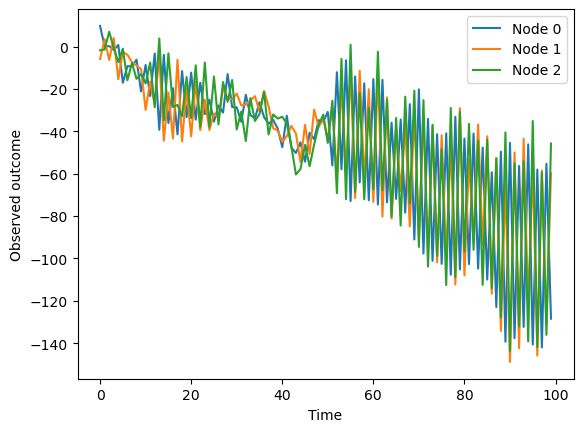

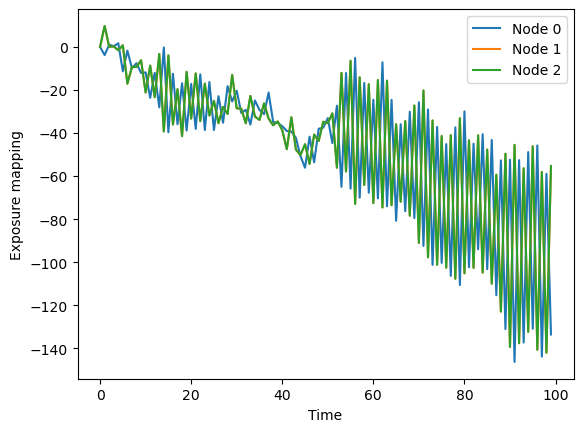

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n):
    ax.plot(obs_outs[:, i], label = f"Node {i}")
ax.set_xlabel("Time")
ax.set_ylabel("Observed outcome")
ax.legend()
fig.show()

fig, ax = plt.subplots()
for i in range(n):
    ax.plot(exp_map[:, i], label = f"Node {i}")
ax.set_xlabel("Time")
ax.set_ylabel("Exposure mapping")
ax.legend()
fig.show()